# Coordinate-based meta-regression algorithms

A tour of CBMR algorithms in NiMARE.

This tutorial is intended to provide a brief description and example of the CBMR algorithm implemented in NiMARE. For a more detailed introduction to the elements of a coordinate-based meta-regression, see other stuff.

In [1]:
import nimare
import os 
from nimare.dataset import Dataset
from nimare.utils import get_resource_path, standardize_field,index2vox
from nimare.meta.cbmr import CBMREstimator
from nilearn.plotting import plot_stat_map
from nimare.generate import create_coordinate_dataset
import nibabel as nib 
import numpy as np

import logging
import sys

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Load Dataset

In [2]:
# data simulation 
ground_truth_foci, dset = create_coordinate_dataset(foci=10, sample_size=(20, 40), n_studies=1000)
# set up group columns: diagnosis & drug_status  
n_rows = dset.annotations.shape[0]
dset.annotations['diagnosis'] = ["schizophrenia" if i%2==0 else 'depression' for i in range(n_rows)]
dset.annotations['drug_status'] = ['Yes' if i%2==0 else 'No' for i in range(n_rows)]
dset.annotations['drug_status'] = dset.annotations['drug_status'].sample(frac=1).reset_index(drop=True) # random shuffle drug_status column
# set up `study-level moderators`: sample sizes & avg_age
dset.annotations["sample_sizes"] = [dset.metadata.sample_sizes[i][0] for i in range(n_rows)] 
dset.annotations["avg_age"] = np.arange(n_rows)
dset = standardize_field(dataset=dset, metadata=["sample_sizes", 'avg_age']) # standardisation
# load mask image from dataset
mask_img = dset.masker.mask_img

## Group-wise spatial intensity estimation

In [3]:
cbmr = CBMREstimator(group_names=['diagnosis', 'drug_status'], moderators=['standardized_sample_sizes', 'standardized_avg_age'], 
                     spline_spacing=10, model='Poisson', penalty=False, lr=1e-1, tol=1, device='cuda')
cbmr_res = cbmr.fit(dataset=dset)
plot_stat_map(
    cbmr_res.get_map("Group_schizophrenia_No_Studywise_Spatial_Intensity"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
)

INFO:nimare.diagnostics:0/10000 coordinates fall outside of the mask. Removing them.


##

## Generalized Linear Hypothesis (GLH) for Spatial homogeneity

/gpfs2/well/nichols/users/pra123/NiMARE/nimare/meta/cbmr.py:416: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975312/work/torch/csrc/utils/tensor_new.cpp:230.)
  involved_spatial_coef = torch.tensor([self.CBMRResults.tables['Spatial_Regression_Coef'].to_numpy()[i, :].reshape((-1,1)) for i in GLH_involved_index], dtype=torch.float64, device=self.device)


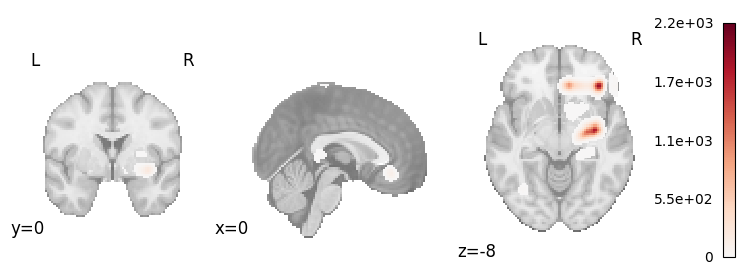

In [ ]:
from nimare.meta.cbmr import CBMRInference
# Group-wise spatial homogeneity test
inference = CBMRInference(CBMRResults=cbmr_res, t_con_group=[[1,0,0,0]],
                          t_con_moderator=None, device='cuda')
inference._contrast()
plot_stat_map(
    cbmr_res.get_map("homo_test_1xschizophrenia_No_chi_sq"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    threshold=5
)

In [5]:
# Group comparison test between two groups
inference = CBMRInference(CBMRResults=cbmr_res, t_con_group=[[1,-1,0,0]],
                          t_con_moderator=None, device='cuda')
inference._contrast()
plot_stat_map(
    cbmr_res.get_map("1xschizophrenia_NoVS1xdepression_Yes_chi_sq"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    threshold=1
)

## Generalized Linear Hypothesis (GLH) for study-level moderators

In [ ]:
# Test for existence of effect of study-level moderators
inference = CBMRInference(CBMRResults=cbmr_res, t_con_group=False,
                          t_con_moderator=[[1,0]], device='cuda')
inference._contrast()
sample_size_p = cbmr_res.tables["Effect_of_1xstandardized_sample_sizes_p"]
print(sample_size_p)

[[0.94563486]]


In [ ]:
# Test for existence of effect of study-level moderators
inference = CBMRInference(CBMRResults=cbmr_res, t_con_group=False,
                          t_con_moderator=[[1,-1]], device='cuda')
inference._contrast()
effect_diff_p = cbmr_res.tables["1xstandardized_sample_sizesVS1xstandardized_avg_age_p"]
print(effect_diff_p)

[[0.99838466]]
